In [1]:
"""
#Amount google drive
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
# LMU is not a rwal university <3
print(sorted(os.listdir()))

#!pip install lightning
#!pip install omegaconf
"""

"\n#Amount google drive\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\n# LMU is not a rwal university <3\nprint(sorted(os.listdir()))\n\n#!pip install lightning\n#!pip install omegaconf\n"

In [2]:
from pathlib import Path
import torch.nn as nn
import os
import itertools
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from utils.dataloaders.full_dataloaders import DataLoaderMNIST, DataLoaderFashionMNIST, DataLoaderCIFAR10, DataLoaderCIFAR100
from utils.visualization import (
    visualize_mapping_error,
    visualize_latent_space_pca,
    plot_latent_space,
    highlight_cluster,
)
from utils.model import load_model, get_transformations

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [3]:
def clear_memory():
    torch.cuda.empty_cache()

def define_dataloader(file, file2, use_test_set=False):
    if file.strip("_")[0] != file2.strip("_")[0]:
        logging.error("The datasets are different")
    # Define the dataloaders
    name_dataset, name_model, size_of_the_latent, seed = file.strip(".pth").split("_")
    augumentation = get_transformations(name_model)
    if name_dataset.lower() == "mnist":
        dataloader = DataLoaderMNIST(transformation=augumentation, batch_size=64, seed=int(seed))
    if name_dataset.lower() == "fmnist":
        dataloader = DataLoaderFashionMNIST(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar10":
        dataloader = DataLoaderCIFAR10(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar100":
        dataloader = DataLoaderCIFAR100(transformation=augumentation,batch_size=64, seed=int(seed))
    if use_test_set:
        full_dataset_images, full_dataset_labels = dataloader.get_full_test_dataset()
    else:
        full_dataset_images, full_dataset_labels = dataloader.get_full_train_dataset()
    return full_dataset_images, full_dataset_labels, len(np.unique(full_dataset_labels.numpy()))

def load_mapping(path,mapping):
    if mapping.lower() == 'linear':
        from optimization.optimizer import LinearFitting
        mapping = LinearFitting.from_file(path)
    elif mapping.lower() == 'affine':
        from optimization.optimizer import AffineFitting
        mapping = AffineFitting.from_file(path)
    elif mapping.lower() == 'neuralnetwork':
        from optimization.optimizer import NeuralNetworkFitting
        mapping = NeuralNetworkFitting.from_file(path)
    else:
        raise ValueError("Invalid experiment name")
    return mapping

In [4]:
##############################################
#Specify here which files you want to use
#Sorry but this fucking thing of the path is ALWAYS broken for me unless I do this. REMOVE when you run this notebook
os.chdir("/Users/federicoferoggio/Documents/vs_code/latent-communication")

#changed the processing of the file: It reads all the transomrations available given cerain filters. It should be possible to pass a single file.
directory_to_explore = 'results/transformations/mapping_files/PCKTAE'
results_list = os.listdir(directory_to_explore)
filters =  ['FMNIST']
results_dataframe  = []
###############################################
criterion = nn.MSELoss()
for file in results_list:
  if file.endswith(".npz"):
    file = file.strip(".npz")
  if file.endswith(".npy"):
    file = file.strip(".npy")
  for filter in filters:
    if filter.lower() in file.lower():
      data_info_1, data_info_2, trans_info = file.split(">")
      name_dataset1, name_model1, size_of_the_latent1, seed1 = data_info_1.split("_")
      name_dataset2, name_model2, size_of_the_latent2, seed2 = data_info_2.split("_")
      list_info_trans = trans_info.strip(".npz").split("_")
      mapping_name, num_samples, lamda_t = list_info_trans.pop(0), list_info_trans.pop(0), list_info_trans.pop(0)
      sampling_strategy = "_".join(list_info_trans)
      file1 = f'models/checkpoints/{name_model1}/{name_dataset1}/{name_dataset1}_{name_model1}_{size_of_the_latent1}_{seed1}.pth'
      file2 = f'models/checkpoints/{name_model2}/{name_dataset2}/{name_dataset2}_{name_model2}_{size_of_the_latent2}_{seed2}.pth'
      model1 = load_model(model_name=name_model1, name_dataset=name_dataset1, latent_size=size_of_the_latent1, seed=seed1, model_path = file1)
      model2 = load_model(model_name=name_model2, name_dataset=name_dataset2, latent_size=size_of_the_latent2, seed=seed2, model_path = file2)
      mapping = load_mapping(directory_to_explore +"/"+ file, mapping_name)
      images, labels, n_classes = define_dataloader(name_dataset1, name_dataset2, use_test_set=True)
      latent_left = model1.get_latent_space(images).detach().cpu().numpy()
      latent_right = model2.get_latent_space(images).detach().cpu().numpy()
      transformed_latent_space = mapping.transform(latent_left)
      decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
      mse_loss = criterion(torch.tensor(decoded_transformed),images).item()
      results_dataframe.append({
        "dataset": name_dataset1,
        "model1": file1,
        "model2": file2,
        "mapping": mapping_name,
        "lambda": lamda_t,
        "num_samples": num_samples,
        "sampling_strategy": sampling_strategy,
        "MSE_loss": mse_loss,
        "class": None
        })

results = pd.DataFrame(results_dataframe)

ValueError: not enough values to unpack (expected 4, got 1)

In [ ]:
#Save results somewhere: TODO change path
path_result="results_stitching.csv"
results.to_csv(path_result)

In [ ]:
results

,dataset,model1,model2,mapping,lambda,num_samples,MSE_loss,class
0,MNIST,VerySmall-AE,VerySmall-AE,Linear,0.00,10,1.017879,None
1,MNIST,VerySmall-AE,VerySmall-AE,Linear,0.10,10,0.947359,None
2,MNIST,VerySmall-AE,VerySmall-AE,Linear,0.01,10,0.966757,None
3,MNIST,VerySmall-AE,VerySmall-AE,Affine,0.00,10,0.974530,None
4,MNIST,VerySmall-AE,VerySmall-AE,Affine,0.10,10,0.968130,None
...,...,...,...,...,...,...,...,...
175,MNIST,VerySmall-AE,VerySmall-AE,Linear,0.10,300,1.001294,None
176,MNIST,VerySmall-AE,VerySmall-AE,Linear,0.01,300,1.002095,None
177,MNIST,VerySmall-AE,VerySmall-AE,Affine,0.00,300,0.868848,None
178,MNIST,VerySmall-AE,VerySmall-AE,Affine,0.10,300,0.985311,None


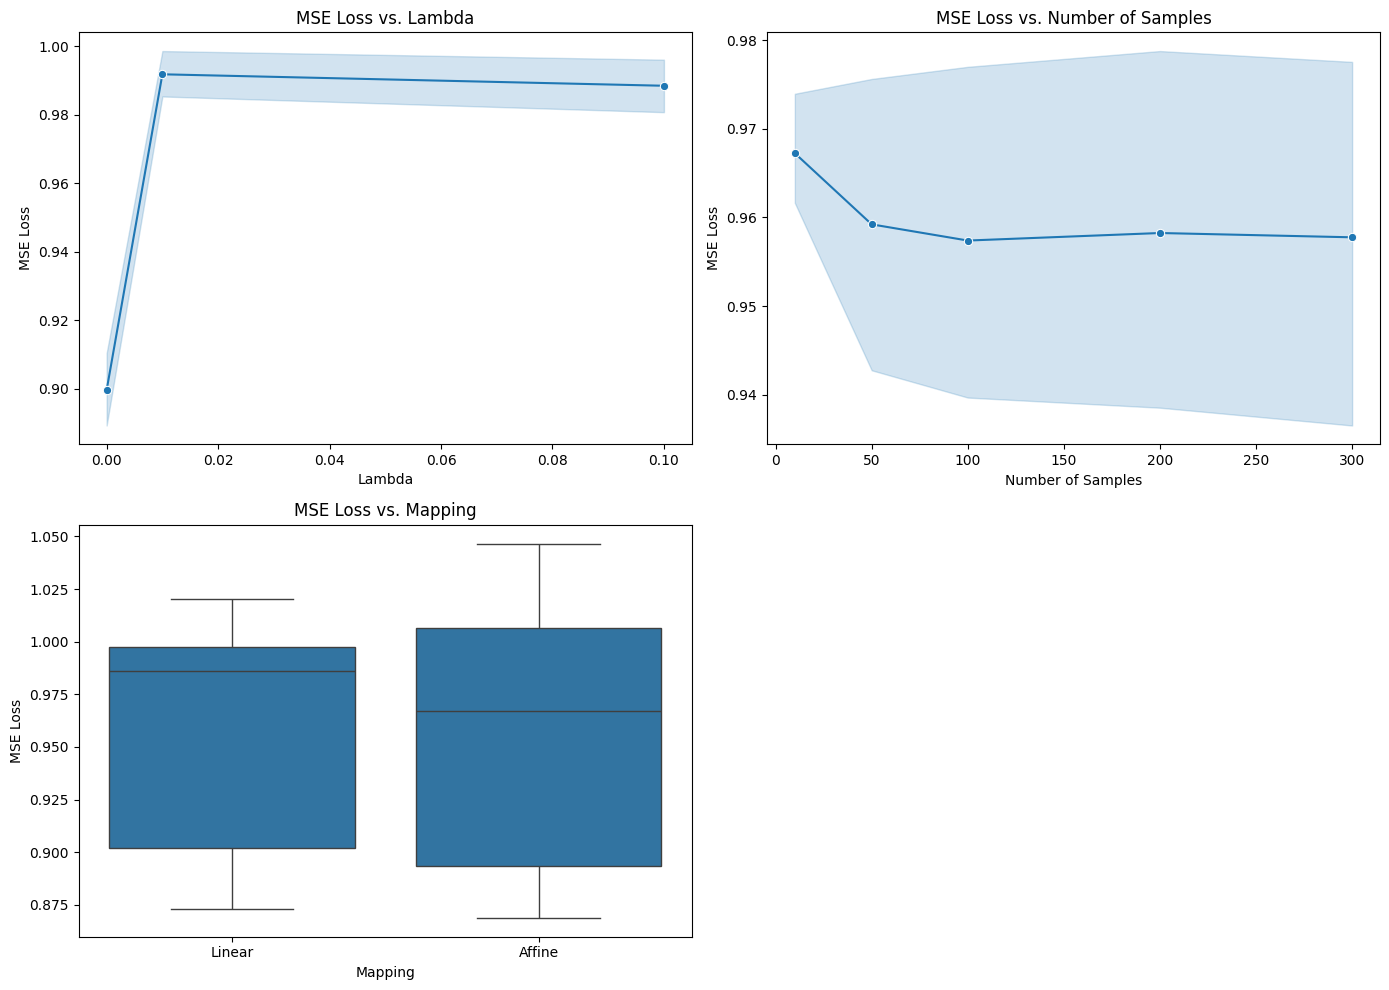

In [ ]:
# Plotting
plt.figure(figsize=(14, 10))

# Plot MSE_loss vs. lambda
plt.subplot(2, 2, 1)
sns.lineplot(data=results, x='lambda', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. num_samples
plt.subplot(2, 2, 2)
sns.lineplot(data=results, x='num_samples', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. mapping (as a categorical variable)
plt.subplot(2, 2, 3)
sns.boxplot(data=results, x='mapping', y='MSE_loss')
plt.title('MSE Loss vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Show all plots
plt.tight_layout()
plt.show()